In [253]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
import ragas
import yaml
import os, sys, datetime
from tqdm import tqdm
import pandas as pd
## load keys from keys.env 
from dotenv import load_dotenv
load_dotenv(dotenv_path='keys.env')
# load the keys from the environment variables
KEYS = {
    'openai': os.getenv('OPENAI_API_KEY')
}
os.environ['OPENAI_API_KEY'] = KEYS['openai']


In [258]:
def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
load_yaml('outputs/tmp.yaml')


{'A-1': {'B-1': [{'value': 'lakfsldkfj', 'label': 1},
   {'value': 'another_value', 'label': 0}],
  'B-2': [{'value': 'lkaslkjdf', 'label': 2}]}}

In [185]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import SingleTurnSample 
from ragas.metrics import ResponseRelevancy, Faithfulness, AspectCritic, FactualCorrectness, BleuScore, RougeScore, SemanticSimilarity
from ragas.metrics._string import NonLLMStringSimilarity, DistanceMeasure
import seaborn as sns
import matplotlib.pyplot as plt
# sns.color_palette('colorblind')
## set colorblind color palette
sns.set_palette('colorblind')


In [4]:

def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
class Labels(object):
    def __init__(self, labels, list_ds_urls, list_metadata_fields):
        self.labels = labels
        self.list_ds_urls = list_ds_urls
        self.list_metadata_fields = list_metadata_fields

    def get(self, url, field):
        assert url in self.list_ds_urls, f"URL {url} not found in labels."
        assert field in self.list_metadata_fields, f"Field {field} not found in metadata fields." 

        if field in self.labels[url].keys():
            return self.labels[url][field]
        else:
            print(f"Field {field} not found in labels for URL {url}. Available fields: {self.list_metadata_fields}")
            print(f"Available fields for {url}: {self.labels[url].keys()}")
            return [None]
        
    def __getitem__(self, url):
        assert url in self.list_ds_urls, f"URL {url} not found in labels."
        return self.labels[url]
    
    def __len__(self):
        return len(self.labels)
    
    def keys(self):
        return self.labels.keys()
    def values(self):
        return self.labels.values()
    def items(self):
        return self.labels.items()
    def __contains__(self, url):
        return url in self.labels
    
    def __repr__(self):
        return f"Labels({len(self.labels)} URLs, {len(self.list_metadata_fields)} metadata fields: {self.list_metadata_fields})"

def load_pred_and_annot(fp_pred, fp_annot='outputs/ground_truth_metadata_annotations-2025-05-30.yaml'):
    labels_annot = load_yaml(fp_annot)
    labels_pred = load_yaml(fp_pred)
    assert set(labels_annot.keys()) == set(labels_pred.keys()), "Keys in annotation and prediction files do not match."
    metadata_fields_annot = list(list(labels_annot.values())[0].keys())
    for _, vals in labels_pred.items():
        assert set(vals.keys()).difference(set(metadata_fields_annot).union(set(['Landing page']))) == set(), "Prediction fields contain unexpected keys."
    list_ds_urls = list(labels_annot.keys())
    labels_annot = Labels(labels_annot, list_ds_urls, metadata_fields_annot)
    labels_pred = Labels(labels_pred, list_ds_urls, metadata_fields_annot)
    print(f"Loaded {len(labels_annot.labels)} annotations and predictions.")
    return labels_annot, labels_pred, (list_ds_urls, metadata_fields_annot)

labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = load_pred_and_annot(fp_pred='outputs/2025-05-28/clean_entity_type_map.yaml')


Loaded 15 annotations and predictions.


Text(0.5, 0, 'Fraction of datasets with annotations')

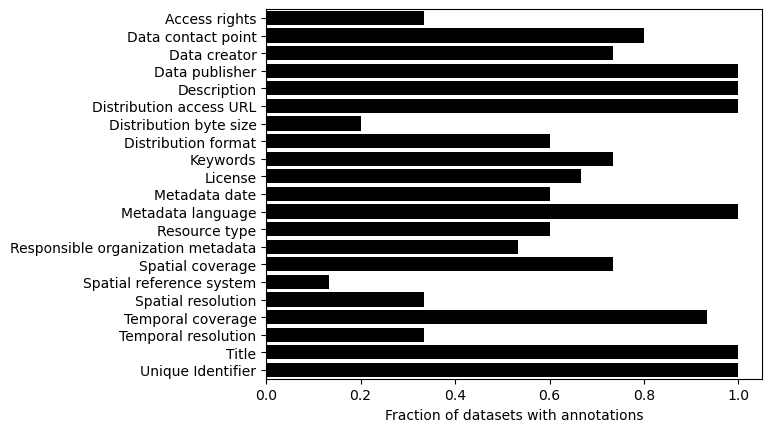

In [5]:
df_annot_present = pd.DataFrame({m: [labels_annot.get(url, m)[0] != 'N/A' for url in labels_annot.keys()] for m in list_metadata_fields})
sns.barplot(data=df_annot_present, orient='h', errorbar=None, color='black')
plt.xlabel('Fraction of datasets with annotations')

In [6]:
for l_name, l in zip(['annotated', 'predicted'], [labels_annot, labels_pred]):
    for url, vals in l.items():
        for meta_key, meta_vals in vals.items():
            if len(meta_vals) > 1:
                print(f"Multiple values for {l_name}: {meta_key} in {url}: {meta_vals}")

In [7]:

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [8]:
list_metadata_fields

['Access rights',
 'Data contact point',
 'Data creator',
 'Data publisher',
 'Description',
 'Distribution access URL',
 'Distribution byte size',
 'Distribution format',
 'Keywords',
 'License',
 'Metadata date',
 'Metadata language',
 'Resource type',
 'Responsible organization metadata',
 'Spatial coverage',
 'Spatial reference system',
 'Spatial resolution',
 'Temporal coverage',
 'Temporal resolution',
 'Title',
 'Unique Identifier']

In [152]:
field_pred

'2016-11-01'

In [132]:
test_faith = True
test_correct = True
test_relevancy = True
test_nonllm_similarity = True
test_embeddings_similarity = False

col_evaluate = 'Metadata date'  # Column to evaluate, e.g., 'Description', 'Title', etc.

ds_scores = {x: [] for x in ['url', 'relevancy', 'bleu', 'faithfulness', 'correctness', 'levenshtein', 'rouge', 'embedding_similarity']}

for url in tqdm(list_ds_urls):
    ds_scores['url'].append(url)

    field_annot = labels_annot.get(url, col_evaluate)[0]
    assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
    if type(field_annot) is datetime.date:
        field_annot = field_annot.strftime('%Y-%m-%d')
    field_pred = labels_pred.get(url, col_evaluate)[0]
    if field_pred is None:
        field_pred = 'N/A'
 
    assert type(field_pred) is str, f"Field {col_evaluate} in predictions for URL {url} is not a string."
    assert type(field_annot) is str, f"Field {col_evaluate} in annotations for URL {url} is not a string."
    
    # context = [f'The {k} of this dataset is {v}' for k, v in labels_annot[url].items() if v != 'N/A']
    # test_data_inference = SingleTurnSample(
    #     user_input=f'What is the {col_evaluate} of this dataset?',
    #     response=field_pred,
    #     retrieved_contexts=context
    # )

    # faith_scorer = Faithfulness(llm=evaluator_llm)
    # faith = await faith_scorer.single_turn_ascore(test_data_faith)
    # ds_scores['faithfulness'].append(faith)

    if field_annot == 'N/A':
        if field_pred is None or field_pred.lower() in ['n/a', 'none', '', 'not specified', 'not available', 'not applicable', 'not provided', 'not given']:
            # If both annotation and prediction are 'N/A', skip this dataset
            ds_scores['rouge'].append(1)
            continue
        # else:
    #         context = [f'The {k} of this dataset is {v}' for k, v in labels_annot[url].items() if v != 'N/A']
    #         test_data_inference = SingleTurnSample(
    #             user_input=f'What is the {col_evaluate} of this dataset?',
    #             response=field_pred,
    #             retrieved_contexts=context
    #         )

    #     faith_scorer = Faithfulness(llm=evaluator_llm)
    #     faith = await faith_scorer.single_turn_ascore(test_data_faith)
    #     ds_scores['faithfulness'].append(faith)
    # else:
    #     ds_scores['faithfulness'].append(None)


    test_data = SingleTurnSample(
        user_input=f'What is the {col_evaluate} of this dataset?',
        response=field_pred,
        reference=field_annot,
        retrieved_contexts=[field_annot]
    )

    if test_nonllm_similarity:
        levenshtein_scorer = NonLLMStringSimilarity(distance_measure=DistanceMeasure.LEVENSHTEIN)
        levenshtein_sim = levenshtein_scorer.single_turn_score(test_data)
        ds_scores['levenshtein'].append(levenshtein_sim)
        rouge_scorer = RougeScore(rouge_type='rougeL', mode='fmeasure')
        rouge_score = rouge_scorer.single_turn_score(test_data)
        ds_scores['rouge'].append(rouge_score)
        blue_scorer = BleuScore()
        blue_score = blue_scorer.single_turn_score(test_data)
        ds_scores['bleu'].append(blue_score)

    if test_relevancy:
        rel_scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
        rel = await rel_scorer.single_turn_ascore(test_data)
        ds_scores['relevancy'].append(rel)
    
    if test_faith:
        faith_scorer = Faithfulness(llm=evaluator_llm)
        faith = await faith_scorer.single_turn_ascore(test_data)
        ds_scores['faithfulness'].append(faith)

    if test_correct:
        correct_scorer = FactualCorrectness(llm=evaluator_llm, mode='f1', atomicity='high', coverage='low')
        correct = await correct_scorer.single_turn_ascore(test_data)
        ds_scores['correctness'].append(correct)

    if test_embeddings_similarity:
        embeddings_scorer = SemanticSimilarity(embeddings=evaluator_embeddings)
        embedding_similarity = await embeddings_scorer.single_turn_ascore(test_data)
        ds_scores['embedding_similarity'].append(embedding_similarity)

ds_scores = {k: v for k, v in ds_scores.items() if len(v) == len(list_ds_urls)}  # Ensure all lists are of equal length

df_scores = pd.DataFrame(ds_scores)
df_scores 

 20%|██        | 3/15 [00:27<01:45,  8.81s/it]

Field Metadata date not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 33%|███▎      | 5/15 [00:37<01:06,  6.70s/it]

Field Metadata date not found in labels for URL https://lpdaac.usgs.gov/products/mod09a1v061/. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://lpdaac.usgs.gov/products/mod09a1v061/: dict_keys(['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'Landing page', 'License', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Uni

 60%|██████    | 9/15 [00:45<00:22,  3.73s/it]

Field Metadata date not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [01:24<00:00,  5.63s/it]


,url,rouge
0,https://datahuiswadden.openearth.nl/geonetwork...,0.000000
1,https://datahuiswadden.openearth.nl/geonetwork...,1.000000
2,https://datahuiswadden.openearth.nl/geonetwork...,0.000000
3,https://developers.google.com/earth-engine/dat...,1.000000
4,https://lifesciences.datastations.nl/dataset.x...,0.000000
5,https://lpdaac.usgs.gov/products/mod09a1v061/,1.000000
6,https://stac.ecodatacube.eu/blue_glad.landsat....,1.000000
7,https://stac.ecodatacube.eu/green_glad.landsat...,1.000000
8,https://stac.ecodatacube.eu/ndvi_glad.landsat....,0.000000
9,https://stac.ecodatacube.eu/veg_quercus.robur_...,1.000000


For missing data:
1. Does the A indicate the info was not available? Yes -> 1
2. No -> Relevancy + Faith from ANNOT TO TEXT??

In [133]:
df_scores
# sns.scatterplot(data=df_scores, x='rouge', y='levenshtein', sizes=(20, 200), alpha=0.6)

,url,rouge
0,https://datahuiswadden.openearth.nl/geonetwork...,0.000000
1,https://datahuiswadden.openearth.nl/geonetwork...,1.000000
2,https://datahuiswadden.openearth.nl/geonetwork...,0.000000
3,https://developers.google.com/earth-engine/dat...,1.000000
4,https://lifesciences.datastations.nl/dataset.x...,0.000000
5,https://lpdaac.usgs.gov/products/mod09a1v061/,1.000000
6,https://stac.ecodatacube.eu/blue_glad.landsat....,1.000000
7,https://stac.ecodatacube.eu/green_glad.landsat...,1.000000
8,https://stac.ecodatacube.eu/ndvi_glad.landsat....,0.000000
9,https://stac.ecodatacube.eu/veg_quercus.robur_...,1.000000


In [131]:
url = list_ds_urls[0]  # Example URL to check

field_annot = labels_annot.get(url, col_evaluate)[0]
assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
field_pred = labels_pred.get(url, col_evaluate)[0]
if field_pred is None:
    field_pred = ''
    
print(f"Dataset URL: {url}")
print(f"Predicted: {field_pred}")
print(f"Annotated: {field_annot}")

df_scores[df_scores['url'] == url]

Dataset URL: https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA
Predicted: 2016-11-01
Annotated: 2024-09-03


,url,faithfulness,rouge
0,https://datahuiswadden.openearth.nl/geonetwork...,1.0,0.0


## Test:



In [150]:
# col_evaluate = 'Metadata date'  # Column to evaluate, e.g., 'Description', 'Title', etc.

ds_scores = {x: [] for x in ['url', 'metadata_field', 'relevancy', 'faithfulness', 'rouge', 'levenshtein', 'annot_missing']}

for col_evaluate in list_metadata_fields:
    print(f"Evaluating field: {col_evaluate}")
    
    for url in tqdm(list_ds_urls):
        ds_scores['url'].append(url)
        ds_scores['metadata_field'].append(col_evaluate)

        field_annot = labels_annot.get(url, col_evaluate)[0]
        assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
        if type(field_annot) is datetime.date:
            field_annot = field_annot.strftime('%Y-%m-%d')
        field_pred = labels_pred.get(url, col_evaluate)[0]
        if field_pred is None:
            field_pred = 'N/A'
    
        assert type(field_pred) is str, f"Field {col_evaluate} in predictions for URL {url} is not a string."
        assert type(field_annot) is str, f"Field {col_evaluate} in annotations for URL {url} is not a string."
        
        context = [f'The {k} of this dataset is {v}' for k, v in labels_annot[url].items() if v != 'N/A']
        test_data = SingleTurnSample(
            user_input=f'What is the {col_evaluate} of this dataset?',
            response=field_pred,
            reference=field_annot,
            retrieved_contexts=context
        )

        faith_scorer = Faithfulness(llm=evaluator_llm)
        faith = await faith_scorer.single_turn_ascore(test_data)
        ds_scores['faithfulness'].append(faith)

        if field_annot == 'N/A':
            ds_scores['annot_missing'].append(True)
            if field_pred is None or field_pred.lower() in ['n/a', 'none', '', 'not specified', 'not available', 'not applicable', 'not provided', 'not given']:
                # If both annotation and prediction are 'N/A', skip this dataset
                ds_scores['rouge'].append(1)
                ds_scores['relevancy'].append(None)
                ds_scores['levenshtein'].append(1)
                continue
        else:
            ds_scores['annot_missing'].append(False)

        levenshtein_scorer = NonLLMStringSimilarity(distance_measure=DistanceMeasure.LEVENSHTEIN)
        levenshtein_sim = levenshtein_scorer.single_turn_score(test_data)
        ds_scores['levenshtein'].append(levenshtein_sim)

        rouge_scorer = RougeScore(rouge_type='rougeL', mode='fmeasure')
        rouge_score = rouge_scorer.single_turn_score(test_data)
        ds_scores['rouge'].append(rouge_score)

        rel_scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
        rel = await rel_scorer.single_turn_ascore(test_data)
        ds_scores['relevancy'].append(rel)

# ds_scores = {k: v for k, v in ds_scores.items() if len(v) == len(list_ds_urls)}  # Ensure all lists are of equal length

# df_scores = pd.DataFrame(ds_scores)
# df_scores 

Evaluating field: Access rights


 60%|██████    | 9/15 [00:24<00:13,  2.28s/it]

Field Access rights not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:39<00:00,  2.67s/it]


Evaluating field: Data contact point


 20%|██        | 3/15 [00:13<00:55,  4.60s/it]

Field Data contact point not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:57<00:00,  3.81s/it]


Evaluating field: Data creator


100%|██████████| 15/15 [01:16<00:00,  5.11s/it]


Evaluating field: Data publisher


 60%|██████    | 9/15 [00:32<00:23,  3.87s/it]

Field Data publisher not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:54<00:00,  3.60s/it]


Evaluating field: Description


100%|██████████| 15/15 [01:25<00:00,  5.67s/it]


Evaluating field: Distribution access URL


 20%|██        | 3/15 [00:13<00:55,  4.63s/it]

Field Distribution access URL not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 60%|██████    | 9/15 [00:35<00:22,  3.74s/it]

Field Distribution access URL not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:57<00:00,  3.83s/it]


Evaluating field: Distribution byte size


 20%|██        | 3/15 [00:06<00:26,  2.22s/it]

Field Distribution byte size not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 60%|██████    | 9/15 [00:17<00:11,  1.84s/it]

Field Distribution byte size not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Evaluating field: Distribution format


 20%|██        | 3/15 [00:09<00:35,  2.97s/it]

Field Distribution format not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:49<00:00,  3.27s/it]


Evaluating field: Keywords


100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


Evaluating field: License


 20%|██        | 3/15 [00:09<00:40,  3.38s/it]

Field License not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:52<00:00,  3.51s/it]


Evaluating field: Metadata date


 20%|██        | 3/15 [00:11<00:43,  3.63s/it]

Field Metadata date not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 33%|███▎      | 5/15 [00:16<00:30,  3.06s/it]

Field Metadata date not found in labels for URL https://lpdaac.usgs.gov/products/mod09a1v061/. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://lpdaac.usgs.gov/products/mod09a1v061/: dict_keys(['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'Landing page', 'License', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Uni

 60%|██████    | 9/15 [00:25<00:16,  2.72s/it]

Field Metadata date not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:44<00:00,  2.96s/it]


Evaluating field: Metadata language


 33%|███▎      | 5/15 [00:19<00:40,  4.01s/it]

Field Metadata language not found in labels for URL https://lpdaac.usgs.gov/products/mod09a1v061/. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://lpdaac.usgs.gov/products/mod09a1v061/: dict_keys(['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'Landing page', 'License', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 

100%|██████████| 15/15 [00:51<00:00,  3.42s/it]


Evaluating field: Resource type


 60%|██████    | 9/15 [00:29<00:18,  3.10s/it]

Field Resource type not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


Evaluating field: Responsible organization metadata


 60%|██████    | 9/15 [00:26<00:15,  2.56s/it]

Field Responsible organization metadata not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:44<00:00,  2.97s/it]


Evaluating field: Spatial coverage


 60%|██████    | 9/15 [00:25<00:13,  2.31s/it]

Field Spatial coverage not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:45<00:00,  3.03s/it]


Evaluating field: Spatial reference system


 20%|██        | 3/15 [00:06<00:28,  2.39s/it]

Field Spatial reference system not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 60%|██████    | 9/15 [00:19<00:12,  2.06s/it]

Field Spatial reference system not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


Evaluating field: Spatial resolution


 60%|██████    | 9/15 [00:27<00:20,  3.42s/it]

Field Spatial resolution not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:43<00:00,  2.92s/it]


Evaluating field: Temporal coverage


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


Evaluating field: Temporal resolution


 20%|██        | 3/15 [00:07<00:33,  2.75s/it]

Field Temporal resolution not found in labels for URL https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002: dict_keys(['Access rights', 'Data creator', 'Data publisher', 'Description', 'Keywords', 'Landing page', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial resolution', 'Temporal coverage', 'Title', 'Unique Identifier'])


 60%|██████    | 9/15 [00:29<00:23,  3.86s/it]

Field Temporal resolution not found in labels for URL https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en. Available fields: ['Access rights', 'Data contact point', 'Data creator', 'Data publisher', 'Description', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Keywords', 'License', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Spatial reference system', 'Spatial resolution', 'Temporal coverage', 'Temporal resolution', 'Title', 'Unique Identifier']
Available fields for https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en: dict_keys(['Data contact point', 'Data creator', 'Description', 'Distribution format', 'Keywords', 'License', 'Metadata language', 'Temporal coverage', 'Title', 'Unique Identifier'])


100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


Evaluating field: Title


100%|██████████| 15/15 [00:58<00:00,  3.87s/it]


Evaluating field: Unique Identifier


100%|██████████| 15/15 [01:09<00:00,  4.61s/it]


In [149]:
url = list_ds_urls[8]  # Example URL to check

field_annot = labels_annot.get(url, col_evaluate)[0]
assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
field_pred = labels_pred.get(url, col_evaluate)[0]
if field_pred is None:
    field_pred = ''
    
print(f"Dataset URL: {url}")
print(f"Predicted: {field_pred}")
print(f"Annotated: {field_annot}")

df_scores[df_scores['url'] == url]

Dataset URL: https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en
Predicted: 2022-07-01 00:00:00 UTC to 2022-08-31 00:00:00 UTC
Annotated: N/A


,url,metadata_field,relevancy,faithfulness,rouge,levenshtein,annot_missing
8,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Metadata date,0.798634,0.0,0.0,0.0,True


In [203]:
url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forests (DANS)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat blue (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat green (EcoDataCube)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'HLS (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS (LP DAAC)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Landsat NDVI (EcoDataCube)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Quercus robur (EcoDataCube)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 (Zenodo)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans (Datahuis Wadden)',
    }

for url in ds_scores['url']:
    if url not in url_to_ds_name:
        print(f"URL {url} not found in url_to_ds_name mapping.")

In [252]:
ds_scores_clean = {k: v for k, v in ds_scores.items() if len(v) == len(list_ds_urls) * len(list_metadata_fields)}  # Ensure all lists are of equal length
print(f'Dropped {len(ds_scores) - len(ds_scores_clean)} columns with missing values.')
df_scores = pd.DataFrame(ds_scores_clean)
df_scores['domain'] = df_scores['url'].apply(lambda x: x.lstrip('https://').split('/')[0])
df_scores['name'] = df_scores['url'].apply(lambda x: url_to_ds_name[x])
df_scores.to_csv('outputs/2025-05-28/eval_clean_2025-06-02.csv', index=False)
df_scores_present = df_scores[df_scores['annot_missing'] == False].copy()
df_scores_missing = df_scores[df_scores['annot_missing'] == True].copy()
fields_fuzzy = ['Description', 'Keywords']
assert all([f in list_metadata_fields for f in fields_fuzzy]), f"Fields {fields_fuzzy} not found in metadata fields."
fields_exact = [f for f in list_metadata_fields if f not in fields_fuzzy]
df_scores_fuzzy = df_scores[df_scores['metadata_field'].isin(fields_fuzzy)].copy()
df_scores_exact = df_scores[df_scores['metadata_field'].isin(fields_exact)].copy()
df_scores_fuzzy_present = df_scores_fuzzy[df_scores_fuzzy['annot_missing'] == False].copy()
df_scores_fuzzy_missing = df_scores_fuzzy[df_scores_fuzzy['annot_missing'] == True].copy()
df_scores_exact_present = df_scores_exact[df_scores_exact['annot_missing'] == False].copy()
df_scores_exact_missing = df_scores_exact[df_scores_exact['annot_missing'] == True].copy()

Dropped 0 columns with missing values.


Text(0.5, 1.0, 'Relevancy for exact metadata fields (present) pm sem')

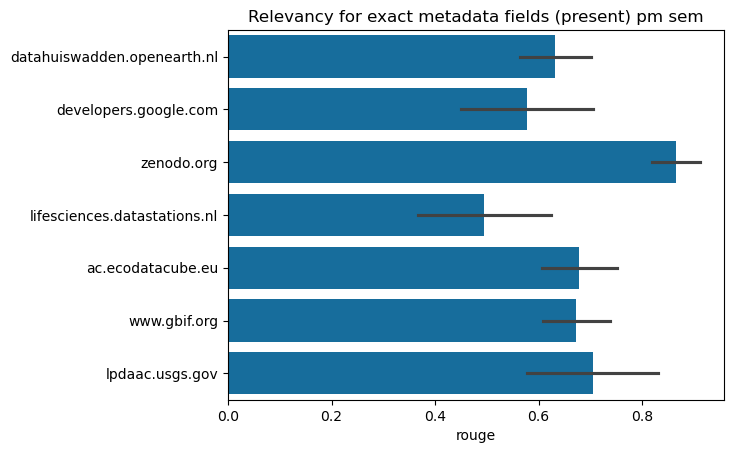

In [251]:
sns.barplot(data=df_scores_exact_present, x='rouge', y='domain', orient='h', errorbar='se')
plt.ylabel('')
# plt.title('Rouge score for exact metadata fields (present) pm sem')
plt.title('Relevancy for exact metadata fields (present) pm sem')

In [248]:
df_scores_exact_missing['relevancy'].isna().sum() / len(df_scores_exact_missing)

np.float64(0.6701030927835051)

In [242]:
df_scores_exact_missing[np.logical_not(df_scores_exact_missing['relevancy'].isna())]

,url,metadata_field,relevancy,faithfulness,rouge,levenshtein,annot_missing,domain,name
11,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Access rights,0.788648,0.0,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)
20,https://lpdaac.usgs.gov/products/mod09a1v061/,Data contact point,0.755360,1.0,0.000000,0.142857,True,lpdaac.usgs.gov,MODIS (LP DAAC)
38,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Data creator,0.756385,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat NDVI (EcoDataCube)
39,https://stac.ecodatacube.eu/veg_quercus.robur_...,Data creator,0.000000,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Quercus robur (EcoDataCube)
92,https://datahuiswadden.openearth.nl/geonetwork...,Distribution byte size,0.000000,1.0,0.000000,0.076923,True,datahuiswadden.openearth.nl,Ecotopenkaart 2017 (Datahuis Wadden)
101,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Distribution byte size,0.778306,0.0,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)
111,https://stac.ecodatacube.eu/blue_glad.landsat....,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat blue (EcoDataCube)
112,https://stac.ecodatacube.eu/green_glad.landsat...,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat green (EcoDataCube)
113,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat NDVI (EcoDataCube)
114,https://stac.ecodatacube.eu/veg_quercus.robur_...,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Quercus robur (EcoDataCube)


In [228]:
url = df_scores_fuzzy_missing['url'].iloc[3]  # Example URL to check
col_evaluate = 'Keywords'  # Column to evaluate, e.g., 'Description', 'Title', etc.
field_annot = labels_annot.get(url, col_evaluate)[0]
assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
field_pred = labels_pred.get(url, col_evaluate)[0]
if field_pred is None:
    field_pred = ''
    
print(f"Dataset name: {url_to_ds_name[url]}")
print(f"Predicted: {field_pred}")
print(f"Annotated: {field_annot}")

df_scores[df_scores['url'] == url]

Dataset name: Waterleidingduinen camera trap P3 (GBIF)
Predicted: Camera trap, lens angle, camera height, herbivore exclosures
Annotated: N/A


,url,metadata_field,relevancy,faithfulness,rouge,levenshtein,annot_missing,domain,name
12,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Access rights,NaN,1.000000,1.000000,1.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
27,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data contact point,0.770615,0.333333,0.583333,0.414414,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
42,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data creator,0.826349,1.000000,0.428571,0.413043,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
57,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data publisher,0.749243,0.000000,0.000000,0.301887,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
72,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Description,0.759030,1.000000,0.207254,0.175000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
87,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution access URL,0.000000,1.000000,1.000000,1.000000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
102,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution byte size,NaN,1.000000,1.000000,1.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
117,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution format,0.000000,1.000000,0.000000,0.125000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
132,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Keywords,0.750340,0.000000,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
147,https://www.gbif.org/dataset/bc0acb9a-131f-408...,License,0.804843,1.000000,1.000000,1.000000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
